<a href="https://colab.research.google.com/github/antonio-decaro/Target-Set-Selection-Experimentations/blob/main/GooglColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Inizializzazione

Importiamo tutte le librerie.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import heapdict
import random
import time
import re
import numpy as np
import math
import csv
import statistics

Inizializziamo il grafo sulla base di un dataset.

In [4]:
g = nx.Graph()

with open('jazz.csv') as f:
  csv_reader = csv.reader(f)
  for row in csv_reader:
    g.add_edge(row[0], row[1])

print(g)
print('Max Degree:', max(g.degree(n) for n in g.nodes()))
print('Min Degree:', min(g.degree(n) for n in g.nodes()))
print('Mean Degree:', math.ceil(statistics.mean(g.degree(n) for n in g.nodes())))
print('Variance Degree:', math.ceil(statistics.variance(g.degree(n) for n in g.nodes())))
print('Standard Deviation Degree:', math.ceil(statistics.pstdev(g.degree(n) for n in g.nodes())))

Graph with 198 nodes and 2742 edges
Max Degree: 100
Min Degree: 1
Mean Degree: 28
Variance Degree: 305
Standard Deviation Degree: 18


## Implementazione di WTSS

Vogliamo implementare l'algoritmo pesato di Target Set Selection

In [ ]:
def argmax(G, t, c):
  def ratio(v):
    d = G.degree(v)
    if d == 0:
      return float('-inf')
    return t[v]/(d * (d+1))

  v = max(G.nodes(), key=lambda x: ratio(x))
  max_ratio = ratio(v)
  max_ratio_nodes = set()
  for v in G.nodes():
    if ratio(v) == max_ratio:
      max_ratio_nodes.add(v)

  v = max(max_ratio_nodes, key=lambda x: c[x])
  return v


def decrease_thresholds(G, v, t):
  for u in G.neighbors(v):
    t[u] -= 1

def clean_graph(G):
  to_remove = set()
  for node in G.nodes():
    if G.degree(node) == 0:
      to_remove.add(node)
  for node in to_remove:
    G.remove_node(node)

In [ ]:
def WTSS(graph, thresholds, costs):
  G = graph.copy()
  t = thresholds.copy()
  S = set()

  while G.number_of_nodes():
    # controlliamo se abbiamo nodi con threshold uguale a 0, e rimuoviamoli dal grafo
    for v in G.nodes():
      if t[v] == 0: # se un nodo ha threshold 0 allora sicuramente è stato influenzato dagli adiacenti, ed influenzerà di conseguenza i suoi adiacenti
        decrease_thresholds(G, v, t)
        break
    else:
      available_nodes = set()
      # aggiungi alla lista dei nodi disponibili tutti quelli che hanno grado inferiore del threhsold
      for node in G.nodes():
        if G.degree(node) < t[node]: # mettiamo in una lista tutti i nodi che non possono essere influenzati e che sono potenziali target
          available_nodes.add(node)
      # se esistono tali nodi, aggiungiamo ad S quello con il costo inferiore
      if available_nodes:
        v = min(available_nodes, key=lambda x: costs[x]) # selezioniamo quello di costo minimo
        S.add(v)
        decrease_thresholds(G, v, t)
      # altrimenti rimuoviamo dal grafo il nodo con ratio maggiore (e con costo maggiore)
      else: 
        v = argmax(G, t, costs)

    G.remove_node(v)
  return S

In [ ]:
from typing import Collection
def differ_decision(graph: nx.Graph, prob) -> nx.Graph:
  dd = graph.copy()

  if type(prob) in (int, float):
    prob = {e: prob for e in graph.edges()}
  else:
    if len(prob) != graph.number_of_edges():
      raise AttributeError('probability list has different size then number of edges')

  for e in graph.edges():
    if round(random.uniform(0, 1), 2) > prob[e]:
      dd.remove_edge(*e)
  return dd

def check_coverage(g, sol):
  explored = set()
  def dfs(v):
    if v not in explored:
      explored.add(v)
    for u in g.neighbors(v):
      if u not in explored:
        dfs(u)

  for node in sol:
    dfs(node)

  return len(explored) == g.number_of_nodes()

## Sperimentazione

Definiamo anzitutto il vettore dei costi

In [ ]:
mean_degree = math.ceil(statistics.mean(g.degree(n) for n in g.nodes()))
max_degree = max(g.degree(n) for n in g.nodes())
unif_max_c = {n: math.log(max_degree) for n in g.nodes()} # costo uniforme
unif_mean_c = {n: math.log(mean_degree) for n in g.nodes()} # costo uniforme
prop_c = {n: math.log(g.degree(n)) for n in g.nodes()} # proporzionale al grado


# print(f'Max: {max(c.values())} | Min: {min(c.values())} | Avg: {round(statistics.mean(c.values()), 2)} | Median: {statistics.median(c.values())}')

### Modello Deterministico
Vogliamo sperimentare il comportamento dell'algoritmo implementato.
Definiamo prima il vettore dei costi `c=[c1,...,cn]`.

#### Threshold costante

Vogliamo verificare il comportamento del nostro algritmo con un threshold costante, nel nostro caso uguale a 2.

In [ ]:
x_const = [2 ** i for i in range(0, 8)]
y_unif_mean_const = []
y_unif_max_const = []
y_prop_const = []

for i in x_const:
  t = {n: i for n in g.nodes()}
  s_prop = WTSS(g, t, prop_c)
  s_unif_mean = WTSS(g, t, unif_mean_c)
  s_unif_max = WTSS(g, t, unif_max_c)

  y_unif_mean_const.append(sum(unif_mean_c[n] for n in s_unif_mean))
  y_unif_max_const.append(sum(unif_max_c[n] for n in s_unif_max))
  y_prop_const.append(sum(prop_c[n] for n in s_prop))

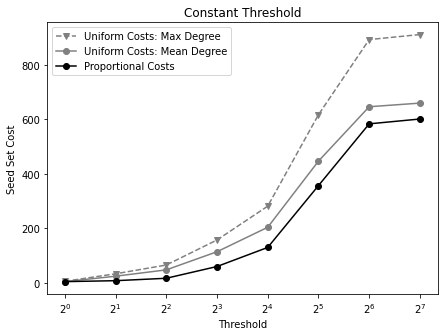

In [ ]:
plt.plot(x_const, y_unif_max_const, 'kv--', color='gray')
plt.plot(x_const, y_unif_mean_const, 'ko-', color='gray')
plt.plot(x_const, y_prop_const, 'ko-')
plt.xlabel('Threshold')
plt.ylabel('Seed Set Cost')
plt.xticks(x_const)
plt.xscale('log', basex=2)
plt.legend(['Uniform Costs: Max Degree', 'Uniform Costs: Mean Degree', 'Proportional Costs'])
plt.title('Constant Threshold')
plt.savefig("threshold_costante.pdf",format="pdf")
plt.show()

#### Threshold Casuale
I valori dei threshold sono casuali in un intervallo [1, d(v)]. 

In [ ]:
x_rand = [n/10 for n in range(1, 11)]
y_unif_max_rand = []
y_unif_mean_rand = []
y_prop_rand = []

ITERATIONS = 10

for alpha in x_rand:
  costs_prop = []
  costs_unif_mean = []
  costs_unif_max = []
  for i in range(ITERATIONS):
    t = {n: random.randint(1, int(alpha * g.degree(n)) + 1) for n in g.nodes()}
    s_prop = WTSS(g, t, prop_c)
    s_unif_max = WTSS(g, t, unif_max_c)
    s_unif_mean = WTSS(g, t, unif_mean_c)
    costs_prop.append(sum(prop_c[n] for n in s_prop))
    costs_unif_mean.append(sum(unif_mean_c[n] for n in s_unif_mean))
    costs_unif_max.append(sum(unif_max_c[n] for n in s_unif_max))
  y_unif_mean_rand.append(statistics.mean(costs_unif_mean))
  y_unif_max_rand.append(statistics.mean(costs_unif_max))
  y_prop_rand.append(statistics.mean(costs_prop))

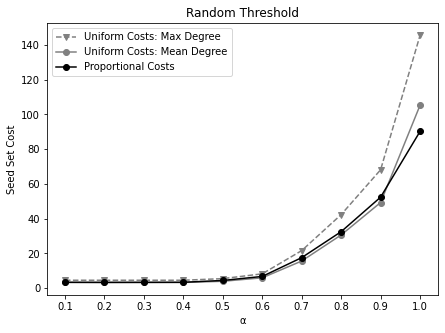

In [ ]:
plt.plot(x_rand, y_unif_max_rand, 'kv--', color='gray')
plt.plot(x_rand, y_unif_mean_rand, 'ko-', color='gray')
plt.plot(x_rand, y_prop_rand, 'ko-')
plt.xlabel('α')
plt.ylabel('Seed Set Cost')
plt.xticks(x_rand)
plt.legend(['Uniform Costs: Max Degree', 'Uniform Costs: Mean Degree', 'Proportional Costs'])
plt.title('Random Threshold')
plt.savefig("threshold_casuale.pdf",format="pdf")
plt.show()

#### Threshold proporzionale al grado

Il threshold è definito in maniera proporzionale al grado del nodo. Si utilizza una costante lambda per modificare il valore del threshold.

Per un nodo *v*: *t(v) = α * d(v)*.

In [ ]:
x_propd = [n/10 for n in range(1, 11)]
y_unif_max_propd = []
y_unif_mean_propd = []
y_prop_propd = []

for alpha in x_propd:
  t = {n: int(g.degree(n) * alpha) for n in g.nodes()}
  s_unif_max = WTSS(g, t, unif_max_c)
  s_unif_mean = WTSS(g, t, unif_mean_c)
  s_prop = WTSS(g, t, prop_c)
  y_unif_mean_propd.append(sum(unif_mean_c[n] for n in s_unif_mean))
  y_unif_max_propd.append(sum(unif_max_c[n] for n in s_unif_max))
  y_prop_propd.append(sum(prop_c[n] for n in s_prop))

33
44
61
84
111
159


##### Risultati

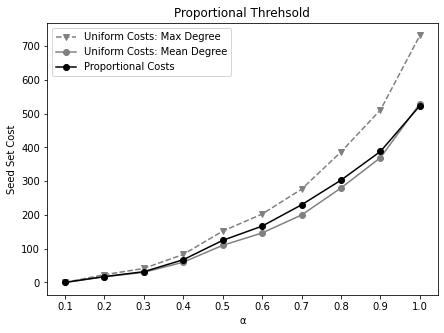

In [ ]:
plt.plot(x_propd, y_unif_max_propd, 'kv--', color='gray')
plt.plot(x_propd, y_unif_mean_propd, 'ko-', color='gray')
plt.plot(x_propd, y_prop_propd, 'ko-')
plt.xlabel('α')
plt.ylabel('Seed Set Cost')
plt.xticks(x_propd)
plt.legend(['Uniform Costs: Max Degree', 'Uniform Costs: Mean Degree', 'Proportional Costs'])
plt.title('Proportional Threhsold')
plt.savefig("threshold_proporzionale.pdf",format="pdf")
plt.show()

### Modello non deterministico
A questo punto cosa succede se invece di utilizzare dei threshold decidessimo di assegnare una probabilità ad ogni arco?
Utilizziamo il __processo di decisione differita__ e calcoliamo il valore medio di diverse iterazioni.

Definiamo inoltre una funzione `check_coeverage` per controllare che venga raggiunto il **Complete Cascade**

#### Probabilità Costante
Utilizziamo per ogni arco una probabilità di attivazione costante.

Utilizziamo threhsold 1 per ogni nodo; in questo modo tutti gli archi attivi verrano utilizzati per influenzare nodi adiacenti.

In [ ]:
ITERATIONS = 10

x_const_prob = [n / 10 for n in range(1, 10)]
y_unif_max_const_prob = []
y_unif_mean_const_prob = []
y_prop_const_prob = []

for prob in x_const_prob:
  tot_unif_max_cost = 0
  tot_unif_mean_cost = 0
  tot_prop_cost = 0
  for i in range(ITERATIONS):
    dd = differ_decision(g, prob)
    unif_max_s = WTSS(dd, {n: 1 for n in g.nodes()}, unif_max_c)
    unif_mean_s = WTSS(dd, {n: 1 for n in g.nodes()}, unif_mean_c)
    prop_s = WTSS(dd, {n: 1 for n in g.nodes()}, prop_c)
    tot_unif_max_cost += sum(unif_max_c[n] for n in unif_max_s)
    tot_unif_mean_cost += sum(unif_mean_c[n] for n in unif_mean_s)
    tot_prop_cost += sum(prop_c[n] for n in prop_s)
    if not check_coverage(dd, unif_max_s) or not check_coverage(dd, unif_mean_s) or not check_coverage(dd, prop_s):
      print('Errore! Complete Cascade non raggiunto')
      break
  y_unif_max_const_prob.append(math.ceil(tot_unif_max_cost / ITERATIONS)) # controllare se è corretto
  y_unif_mean_const_prob.append(math.ceil(tot_unif_mean_cost / ITERATIONS)) # controllare se è corretto
  y_prop_const_prob.append(math.ceil(tot_prop_cost / ITERATIONS)) # controllare se è corretto

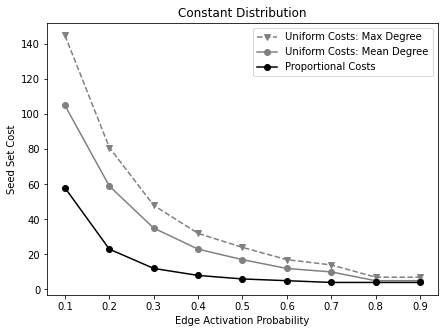

In [ ]:
plt.plot(x_const_prob, y_unif_max_const_prob, 'kv--', color='gray')
plt.plot(x_const_prob, y_unif_mean_const_prob, 'ko-', color='gray')
plt.plot(x_const_prob, y_prop_const_prob, 'ko-')
plt.xlabel('Edge Activation Probability')
plt.ylabel('Seed Set Cost')
plt.xticks(x_const_prob)
plt.title('Constant Distribution')
plt.legend(['Uniform Costs: Max Degree', 'Uniform Costs: Mean Degree', 'Proportional Costs'])
plt.savefig("prob_costante.pdf",format="pdf")
plt.show()

#### Distribuzioni

Utilizziamo una probabilità per ogni arco (u, v) pari a (deg(u) + deg(v))/(n-1)

In [ ]:
x_prob = ['Degree Centrality', 'Proportional']
y_unif_max_prob = [None, None]
y_unif_mean_prob = [None, None]
y_prop_prob = [None, None]

##### Degree Centrality

In [ ]:
PROB = {e: round((g.degree(e[0]) + g.degree(e[1])) / g.number_of_nodes(), 2) for e in g.edges()}
ITERATIONS = 10

tot_unif_max_cost = 0
tot_unif_mean_cost = 0
tot_prop_cost = 0
for i in range(ITERATIONS):
  dd = differ_decision(g, PROB)
  unif_max_s = WTSS(dd, {n: 1 for n in g.nodes()}, unif_max_c)
  unif_mean_s = WTSS(dd, {n: 1 for n in g.nodes()}, unif_mean_c)
  prop_s = WTSS(dd, {n: 1 for n in g.nodes()}, prop_c)
  tot_unif_max_cost += sum(unif_max_c[n] for n in unif_max_s)
  tot_unif_mean_cost += sum(unif_mean_c[n] for n in unif_mean_s)
  tot_prop_cost += sum(prop_c[n] for n in prop_s)
  if not check_coverage(dd, unif_max_s) or not check_coverage(dd, prop_s):
    print('Errore! Complete Cascade non raggiunto')
    break

y_unif_max_prob[0] = math.ceil(tot_unif_max_cost / ITERATIONS)
y_unif_mean_prob[0] = math.ceil(tot_unif_mean_cost / ITERATIONS)
y_prop_prob[0] = math.ceil(tot_prop_cost / ITERATIONS)

##### Proporzionale al grado


In [ ]:
PROB = {e: round(1/g.degree(e[1]), 2) for e in g.edges()}

ITERATIONS = 10

tot_unif_max_cost = 0
tot_unif_mean_cost = 0
tot_prop_cost = 0
for i in range(ITERATIONS):
  dd = differ_decision(g, PROB)
  unif_max_s = WTSS(dd, {n: 1 for n in g.nodes()}, unif_max_c)
  unif_mean_s = WTSS(dd, {n: 1 for n in g.nodes()}, unif_mean_c)
  prop_s = WTSS(dd, {n: 1 for n in g.nodes()}, prop_c)
  tot_unif_max_cost += sum(unif_max_c[n] for n in unif_max_s)
  tot_unif_mean_cost += sum(unif_mean_c[n] for n in unif_mean_s)
  tot_prop_cost += sum(prop_c[n] for n in prop_s)
  if not check_coverage(dd, unif_max_s) or not check_coverage(dd, prop_s):
    print('Errore! Complete Cascade non raggiunto')
    break

y_unif_max_prob[1] = math.ceil(tot_unif_max_cost / ITERATIONS)
y_unif_mean_prob[1] = math.ceil(tot_unif_mean_cost / ITERATIONS)
y_prop_prob[1] = math.ceil(tot_prop_cost / ITERATIONS)

##### Risultati

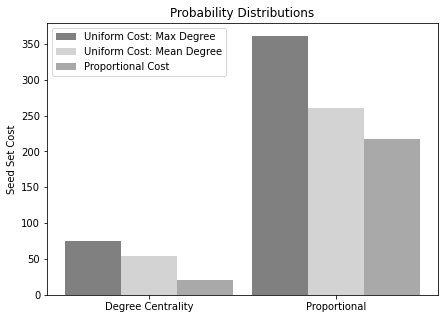

In [ ]:
x_axis = np.arange(len(x_prob))
  
plt.bar(x_axis - 0.3, y_unif_max_prob, 0.3, label = 'Uniform Cost: Max Degree', color='gray')
plt.bar(x_axis - 0.0, y_unif_mean_prob, 0.3, label = 'Uniform Cost: Mean Degree', color='lightgray')
plt.bar(x_axis + 0.3, y_prop_prob, 0.3, label = 'Proportional Cost', color='darkgray')
  
plt.xticks(x_axis, x_prob)

plt.title("Probability Distributions")
plt.ylabel('Seed Set Cost')
plt.legend()
plt.savefig("prob_distribuzione.pdf",format="pdf")
plt.show()